In [13]:
"""
Import necessary libraries
"""
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [22]:

def initialize_grid(N, boundary_val):
    """
    This function intitializes the 2-dimensional grid
    upon which the dielectric breakdown model algorithm is
    implemented. Basically, this code sets the boundary
    conditions and the seed of the tree.
    """

    #create NxN array of empty tuples
    grid = np.empty((N, N), dtype=np.dtype([('potential', float), ('is_tree', bool)]))

    #initialize values of grid
    # grid['potential'] = create_radial_array(N, 0, boundary_val)
    grid['potential'] = 0.0
    grid['is_tree'] = False

    #create seed of the electrical tree in the center of the grid
    grid[N//2, N//2] = (0.0, True)

    #set boundary conditions
    grid[0, :]['potential']     = boundary_val  # Top boundary
    grid[-1, :]['potential']    = boundary_val  # Bottom boundary
    grid[:, 0]['potential']     = boundary_val  # Left boundary
    grid[:, -1]['potential']    = boundary_val  # Right boundary

    # plt.imshow(grid['potential'])
    # plt.show()

    return grid


def convolve_2d(grid):
    """
    This function applies a naive implementation of convolution
    in order to solve the Laplace equation on a 2-dimensional grid.
    """
    convolved_grid = np.copy(grid)
    height, width = grid.shape

    for r in range(1, height-1):
        for c in range(1, width-1):
            if not grid[r, c]['is_tree']:
                #implicitly uses Laplacian kernel: ([[0, 1/4, 0],[1/4, 0, 1/4],[0, 1/4, 0]])
                adjacent_potentials = np.array((
                    grid[r+1,c]['potential'],
                    grid[r-1,c]['potential'],
                    grid[r,c+1]['potential'],
                    grid[r,c-1]['potential']
                ))
                convolved_grid[r, c]['potential'] = np.mean(adjacent_potentials)

    return convolved_grid


def solve_laplace(grid, threshold):
    """
    This function solves the Laplace equation on the grid
    until convergence.
    """

    error = 1e6
    while error > threshold:
        convolved_grid = convolve_2d(grid)
        error = np.mean(np.square((grid['potential'] - convolved_grid['potential'])))
        grid = convolved_grid

    return grid

def choose_coordinate(probabilities):
    """
    This function chooses a coordinate according to the values in a
    2-dimensional probability distribution.
    """
    # Flatten the 2D array and use numpy.random.choice to pick an index
    flat_indices = np.arange(probabilities.size)
    chosen_index = np.random.choice(flat_indices, p=probabilities.flatten())

    # Convert the flat index back to 2D coordinates
    chosen_coordinates = np.unravel_index(chosen_index, probabilities.shape)

    return chosen_coordinates

def softmax(x):
    """
    This function converts a set of numbers into a valid discrete probability
    distribution.
    """
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

def grow_tree(grid, eta, frames_prob, i):
    """
    This function increases the size of the electrical tree by 1.
    It does so by first obtaining the coordinates of all cells adjacent
    to the current tree's cells. Next, it computes the probabilities
    that each cell has to become part of the tree in accordance with the
    solution to Laplace's equation and the power law equation used in the DBM.
    Finally, it chooses a cell which then becomes part of the tree.
    """
    rows, cols = grid.shape
    probs = np.zeros((rows, cols))
    new_grid = grid.copy()

    possible_growth_coords = set()
    for r in range(1, rows-1):
        for c in range(1, cols-1):
            if grid[r, c]['is_tree']:
                for adj_cell in ((r+1, c), (r-1, c), (r, c+1), (r, c-1)):
                    if not grid[adj_cell]['is_tree']:
                        possible_growth_coords.add(adj_cell)

    potentials_at_possibles = np.array([grid[coord]['potential']**eta for coord in possible_growth_coords])
    total_potential_at_possibles = np.sum(potentials_at_possibles)

    for possible_coord in possible_growth_coords:
        probs[possible_coord] = (grid[possible_coord]['potential']**eta) / total_potential_at_possibles
    frames_prob[i,:,:] =        np.copy(probs)

    coord_of_tree_growth = choose_coordinate(probs)
    new_grid[coord_of_tree_growth] = (0.0, True)#, False)

    return new_grid


def visualize_grid(grid, field):
    """
    This is a helper function which visualizes a grid.
    """
    height, width = grid.shape
    if field == 'probs':
        plt.imshow(grid)
    elif field == 'is_tree':
        plt.imshow(grid[field])
    elif field == 'potential_contour':
        plt.contour(np.arange(height), np.arange(width), grid[field], levels=15)
        plt.colorbar(label=field)
    else:
        plt.imshow(grid[field])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


def get_rg(grid):
    """
    This function gets the radius of gyration by computing the RMS distance
    of points in the tree from the tree's center of mass.
    """
    nonzero_indices = np.argwhere(grid == 1)
    center_of_mass = np.mean(nonzero_indices, axis=0)
    return np.sqrt(np.mean(np.sum((nonzero_indices - center_of_mass)**2, axis=1)))

def get_cm(grid):
    """
    This function gets the center of mass of the tree.
    """
    nonzero_indices = np.argwhere(grid == 1)
    return np.mean(nonzero_indices, axis=0)

def get_gyration_tensor(grid):
    """
    This function gets the gyration tensor of a tree.
    """
    tree_cell_indices = np.argwhere(grid == 1)
    num_tree_cells = np.sum(grid)
    cm = get_cm(grid)
    x_coords = tree_cell_indices[:, 0] - cm[0]
    y_coords = tree_cell_indices[:, 1] - cm[1]

    gt = np.zeros((2, 2))
    gt[0, 0] = np.sum(x_coords**2)
    gt[1, 1] = np.sum(y_coords**2)
    gt[0, 1] = np.sum(x_coords * y_coords)
    gt[1, 0] = np.sum(x_coords * y_coords)

    return gt / num_tree_cells

def get_principle_moments(gt):
    """
    This function gets the principle moments of the gyration tensor.
    """
    return np.linalg.eigvals(gt)

def get_radius_of_gyration(moments, num_cells):
    """
    This function computes the radius of gyration from the principle moments
    of the gyration tensor.
    """
    return np.sqrt(np.sum(moments))

def get_acylindricity(moments):
    """
    This function computes the acylindricity of a tree from the difference in
    its moments.
    """
    return np.abs(moments[1] - moments[0])


# def run_dbm_(num_tree_cells, N, threshold, boundary_val, eta):
#     grid = initialize_grid(N, boundary_val)
#     convolved_grid = solve_laplace(grid, threshold)

#     radii_of_gyration = []
#     new_grid = None
#     for i in range(1, num_tree_cells):
#         new_grid = grow_tree(convolved_grid, eta, frames_prob, i)
#         convolved_grid = solve_laplace(new_grid, threshold)

#         rg = get_rg(new_grid['is_tree'])
#         gt = get_gyration_tensor(new_grid['is_tree'])
#         moments = get_principle_moments(gt)
#         num_cells = np.sum(new_grid['is_tree'])
#         radius_of_gyration = get_radius_of_gyration(moments, num_cells)
#         acylindricity = get_acylindricity(moments)
#         radii_of_gyration.append(rg)

#     return convolved_grid['is_tree']


def run_dbm(num_tree_cells, N, threshold, boundary_val, eta):
    """
    This function runs the dielectric breakdown model in accordance with the
    hyperparameters set by the user.
    """
    if not isinstance(num_tree_cells, int):
        raise TypeError("num_tree_cells must be an integer.")
    if not isinstance(N, int):
        raise TypeError("N must be an integer.")
    if not isinstance(threshold, (float, int)):
        raise ValueError("threshold must be a float or an integer.")
    if not isinstance(boundary_val, (float, int)):
        raise TypeError("boundary_val must be a float or an integer.")
    if not isinstance(eta, (float, int)):
        raise ValueError("eta must be a float or an integer.")


    grid = initialize_grid(N, boundary_val)
    convolved_grid = solve_laplace(grid, threshold)
    # visualize_grid(convolved_grid, field='potential')
    # visualize_grid(convolved_grid, field='is_tree')

    num_frames = num_tree_cells
    frames_is_tree =    np.random.rand(num_frames, N, N)
    frames_contour =    np.random.rand(num_frames, N, N)
    frames_potential =  np.random.rand(num_frames, N, N)
    frames_prob =       np.random.rand(num_frames, N, N)

    frames_is_tree[0,:,:] =     np.copy(convolved_grid['is_tree'])
    frames_contour[0,:,:] =     np.copy(convolved_grid['potential'])
    frames_potential[0,:,:] =   np.copy(convolved_grid['potential'])

    frames_prob[0, N//2+1, N//2] = 0.25
    frames_prob[0, N//2-1, N//2] = 0.25
    frames_prob[0, N//2, N//2+1] = 0.25
    frames_prob[0, N//2, N//2-1] = 0.25

    radii_of_gyration = []
    acylindricities =   []
    new_grid = None
    for i in range(1, num_tree_cells):
        new_grid = grow_tree(convolved_grid, eta, frames_prob, i)
        convolved_grid = solve_laplace(new_grid, threshold)

        frames_is_tree[i,:,:] =   np.copy(convolved_grid['is_tree'])
        frames_contour[i,:,:] = np.copy(convolved_grid['potential'])
        frames_potential[i,:,:] =   np.copy(convolved_grid['potential'])

        # visualize_grid(new_grid, field='is_tree')
        # visualize_grid(convolved_grid, field='potential')

        rg = get_rg(new_grid['is_tree'])
        gt = get_gyration_tensor(new_grid['is_tree'])
        moments = get_principle_moments(gt)
        num_cells = np.sum(new_grid['is_tree'])
        radius_of_gyration = get_radius_of_gyration(moments, num_cells)
        acylindricity = get_acylindricity(moments)
        radii_of_gyration.append(rg)
        acylindricities.append(acylindricity)

        # print(f'rg at {i} points: {rg}')
        # print(f'radius of gyration at {i} points: {radius_of_gyration}')
        # print(f'acylindricity at {i} points: {acylindricity}')

        # if i % 50 == 0:
        #     rg = get_radius_of_gyration(new_grid['is_tree'])
        #     print(f'radius of gyration at {i} points: {rg}')


    print('rg: ', radii_of_gyration[-1])
    print('acylindricity: ', acylindricities[-1])

    fig_is_tree, ax_is_tree = plt.subplots()
    fig_contour, ax_contour = plt.subplots()
    fig_potential, ax_potential = plt.subplots()
    fig_prob, ax_prob = plt.subplots()

    img_is_tree =   ax_is_tree.imshow(convolved_grid['is_tree'],    cmap='viridis', animated=True)
    img_contour =   ax_contour.imshow(convolved_grid['potential'],  cmap='viridis', animated=True)
    img_potential = ax_potential.imshow(convolved_grid['potential'],  cmap='viridis', animated=True)
    img_prob =      ax_prob.imshow(frames_prob[-1,:,:],          cmap='viridis', animated=True)

    def update_is_tree(frame):
        img_is_tree.set_array(frames_is_tree[frame])
        return img_is_tree,

    def update_potential(frame):
        img_potential.set_array(frames_potential[frame])
        return img_potential,

    def update_prob(frame):
        img_prob.set_array(frames_prob[frame])
        return img_prob,

    def update_contour(frame):
        ax_contour.clear()
        contour = ax_contour.contour(frames_contour[frame], levels=15)
        return contour.collections

    animation_is_tree =   FuncAnimation(fig_is_tree,        update_is_tree,     frames=num_frames, interval=100, blit=True)
    animation_contour = FuncAnimation(fig_contour,          update_contour,     frames=num_frames, interval=100, blit=True)
    animation_potential = FuncAnimation(fig_potential,      update_potential,   frames=num_frames, interval=100, blit=True)
    animation_prob = FuncAnimation(fig_prob,                update_prob,        frames=num_frames, interval=100, blit=True)

    save_path_is_tree =     f'/content/is_tree_{eta}.gif'
    save_path_contour =     f'/content/contour_{eta}.gif'
    save_path_potential =   f'/content/potential_{eta}.gif'
    save_path_prob =        f'/content/prob_{eta}.gif'

    animation_is_tree.save(save_path_is_tree)
    animation_contour.save(save_path_contour)
    animation_potential.save(save_path_potential)
    animation_prob.save(save_path_prob)

    return convolved_grid['is_tree']


rg:  4.109263248374877
acylindricity:  6.496993066463822
rg:  4.388267185221165
acylindricity:  5.779064198669683
rg:  5.869150989140877
acylindricity:  21.52972696487864
rg:  5.164769544175659
acylindricity:  8.318670009556888


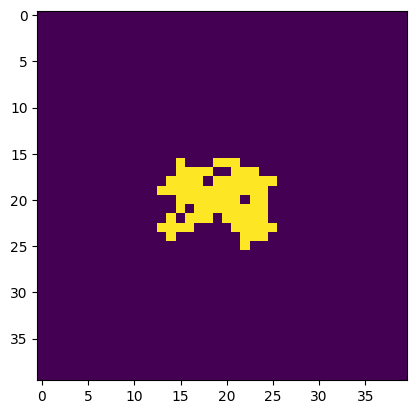

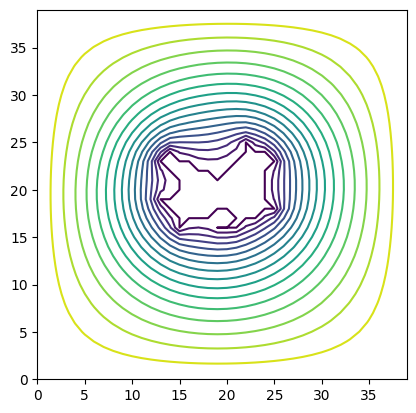

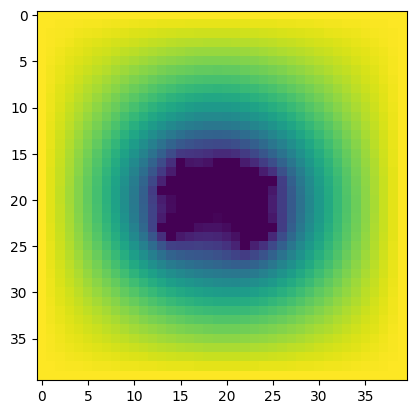

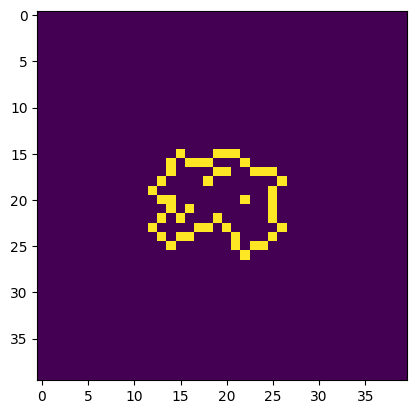

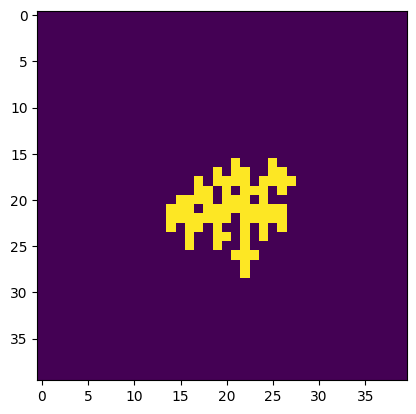

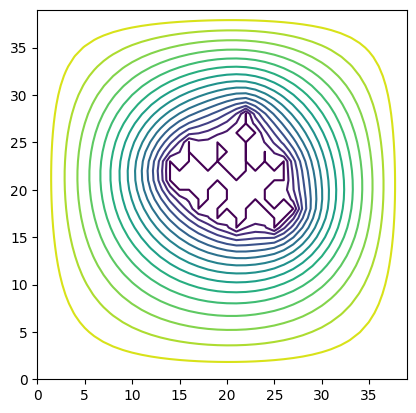

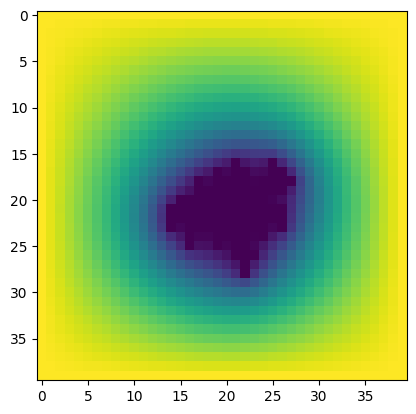

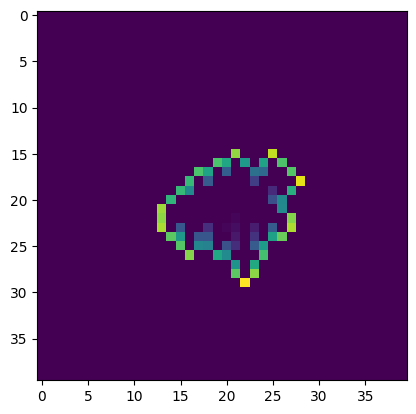

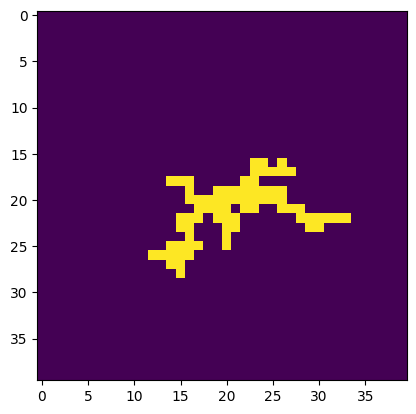

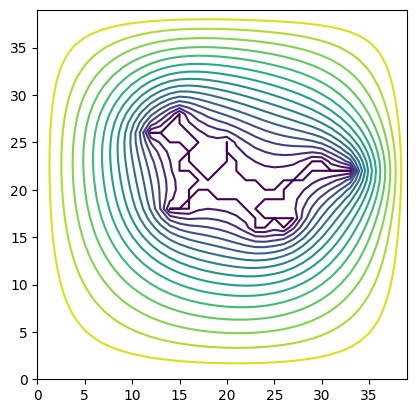

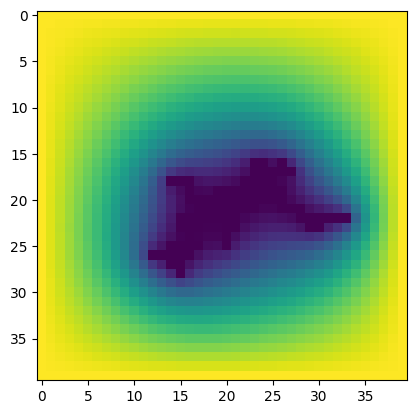

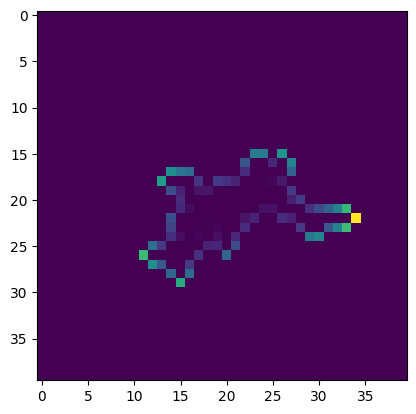

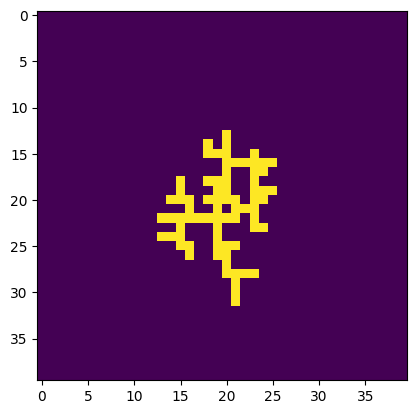

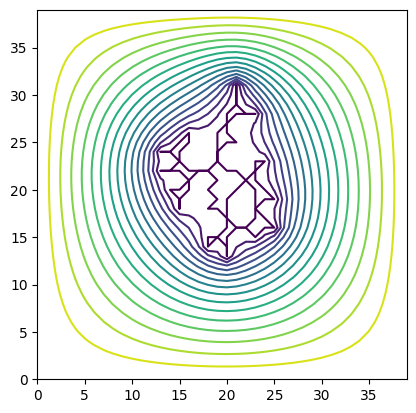

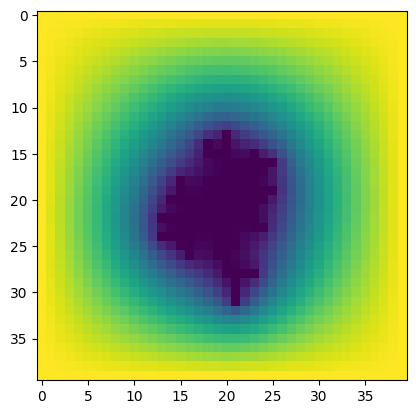

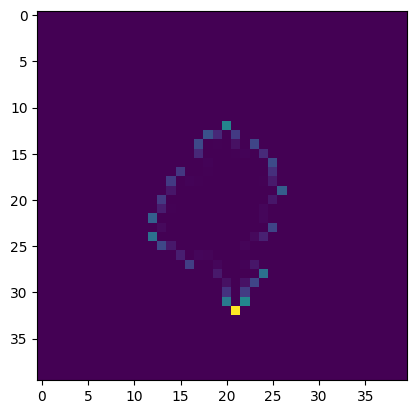

In [24]:
"""
Alter the following parameters of the DBM to change its general behavior.
This model is stochastic, so you will likely never obtain replicate trees even
if parameters are equal.
"""
num_tree_cells = 75
N = 40
threshold = 1e-5
boundary_val = 8

for eta in (0, 0.5, 1, 2):
# for eta in (1,):
    is_tree = run_dbm(num_tree_cells, N, threshold, boundary_val, eta)
